In [10]:
import requests
from requests.exceptions import HTTPError

import pandas as pd
from decimal import Decimal
from pandas.io.json import json_normalize
import json

import numpy as np
import datetime
from pandas_datareader import data as pdr



In [11]:
#Variables/Params
api_key = '46583da07984f6f5e5acc0442fad24656e164280da7811e9aefa8bcfc9d1' #defi pulse
request = '/defipulse/api/getLendingHistory' #getlending history
#add support for BulkAPIMonitor
requesturl = 'https://data-api.defipulse.com/api/v1' + request +'?api-key=' + api_key + '&period=1y'


In [3]:
#get json query
try:
    response = requests.get(requesturl)
    response.raise_for_status()
    # access JSOn content
    api_output = response.json()
    #print("Entire JSON response")
    #print(api_output[0]) #validate response from API

except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
except Exception as err:
    print(f'Other error occurred: {err}')


In [4]:
output = json.dumps(api_output,sort_keys=True, indent=4)
f = open( 'jsonoutput.txt', 'w' )
f.write(output)
f.close()


In [5]:
#extract lending data and dump into a dataframe
df = pd.DataFrame.from_dict(api_output)
df1 = df[['timestamp','lend_rates']]
timestamps = df1['timestamp']
timestamps = pd.to_datetime(timestamps,unit='s')
data = pd.json_normalize(df1['lend_rates'])
lendingdata = pd.merge(timestamps, data, left_index=True, right_index=True)
lendingdata = lendingdata.loc[:,lendingdata.columns != 'timestamp'].pct_change()

In [6]:
from scipy.stats import norm
import matplotlib.pyplot as plt

#####################################
#Params
#####################################
num_days = int(90)


#Portfolio Weights
weights = np.array([.25, .25, .125, .125, .125, .125])
initial_investment = 1000000 # 1 mill

# Select our confidence interval 
conf_level1 = 0.25 ##95%


In [7]:
cov_matrix = lendingdata.cov() #compute covariance
cov_matrix

avg_rets = lendingdata.mean() #FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
#print(avg_rets) #computed mean returns returns

#Calculate mean returns for portfolio overall, use dot products.
#normalize individual means against investment weights
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

#var calculation
var_1d1 = initial_investment - cutoff1
#var_1d1

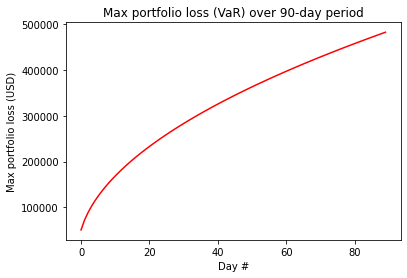

In [8]:
# Calculate n Day VaR
var_array = []
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    #print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over " + str(num_days) + "-day period")
plt.plot(var_array, "r")

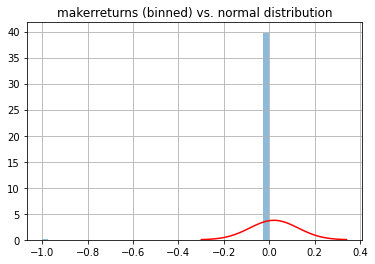

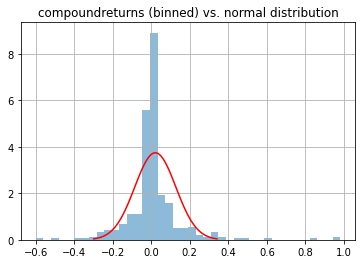

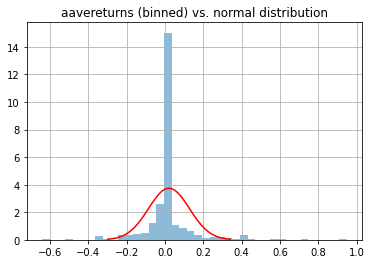

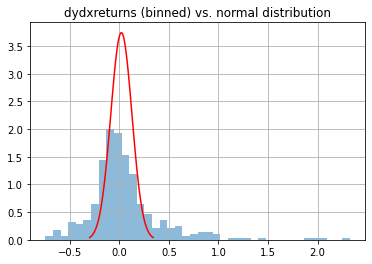

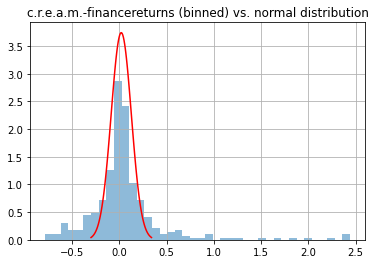

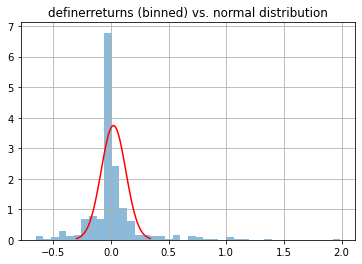

In [9]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy
# Repeat for each equity in portfolio
#list of protocols

def vargraph(dataframe,protocolname):
    dataframe[protocolname].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
    x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
    plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
    plt.title(str(protocolname) + "returns (binned) vs. normal distribution")
    return plt.show()

for protocol in list(lendingdata.columns.values):
    vargraph(lendingdata, protocol)
    